## Project 2 Machine Learing (Neural Network)

In [467]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer

import math
from sklearn import datasets
from keras.datasets import mnist

from sklearn.metrics import accuracy_score

## Functions To Call

In [468]:
def forward(Oi, Wji):
    net_h = np.dot(Oi, Wji)
    Oj = 1 / (1 + np.exp(-net_h))  # Sigmoid activation function
    return Oj 

def backward_out(eta,Oj, Oi,target):
    target = np.array(target)
    Oj = np.array(Oj)
    Oi = np.array(Oi)
    sgma_j = (target - Oj) * Oj * (1 - Oj) # Calculate the error signal at the output layer
    delta_wj = eta * np.outer(sgma_j, Oi) # Calculate the weight update using the error signal and input values
    return delta_wj.T,sgma_j

def backward_hidden_layer(eta, Oj, Oi, sgmak, wkj):
    sgma_j = np.dot(sgmak, wkj.T) * Oj * (1 - Oj)
    delta_wj = eta * np.outer(sgma_j, Oi)
    return delta_wj.T,sgma_j

## Neural Network Implementation

In [469]:
def NN(x_train,y_train,x_test,eta=1,N_Max=10000,prec_err_enhc=0.01,accuracy=0.95,n=1):
    """
    Neural Network Implementation
    
    Parameters:
    - x_train: Training features (2D array-like)
    - y_train: Training labels (1D array-like)
    - x_test: Testing features (2D array-like)
    - eta: Learning rate (default=1)
    - N_Max: Maximum number of iterations (default=10000)
    - prec_err_enhc: Precision error enhancement for stopping criteria (default=0.01)
    - accuracy: Desired accuracy for stopping criteria (default=0.95)
    - n: Number of hidden layers (1 or 2, default=1)
    
    Returns:
    - y_pred: Predicted labels for the testing set (1D array)
    """
    # Extracting dimensions and initializing weight matrices
    N_features = len(x_train[0])
    N_samples = len(x_train)
    N_test_samples = len(x_test)
    N_classes = len(np.unique(y_train))
    N_neurons = 2*N_features

    # Random initialization of weight matrices
    w_s_to_1 = np.random.randn(N_features,N_neurons)
    w_1_to_2 = np.random.randn(N_neurons, N_neurons)
    w_2_to_e = np.random.randn(N_neurons,N_classes) 
    
    #  on Hot encoding
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(y_train)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')
    t = onehot_encoder.fit_transform(integer_encoded)
    
    for i in range(N_Max):
        index =0
        w_s_to_1_das = w_s_to_1
        w_1_to_2_das = w_1_to_2
        w_2_to_e_das = w_2_to_e
        while index<N_samples:
            if (n == 2):
                #forward
                O_1 = forward(x_train[index],w_s_to_1)
                O_2 = forward(O_1,w_1_to_2)
                O_3 = forward(O_2,w_2_to_e)
                #backward_from_out
                delta_w_3,sgma_3 = backward_out(eta,O_3, O_2,t[index])
                w_2_to_e = w_2_to_e + delta_w_3
                #backward_from_hidden_layer
                delta_w_2,sgma_2 = backward_hidden_layer(eta, O_2, O_1, sgma_3, w_2_to_3)
                w_1_to_2 = w_1_to_2 + delta_w_2
                delta_w_1,sgma_1 = backward_hidden_layer(eta, O_1, x_train[index], sgma_2, w_1_to_2)
                w_s_to_1 = w_s_to_1 + delta_w_1
            elif (n==1):
                O_1 = forward(x_train[index],w_s_to_1)
                O_2 = forward(O_1,w_2_to_e)
                #backward_from_out
                delta_w_2,sgma_2 = backward_out(eta,O_2, O_1,t[index])
                w_2_to_e = w_2_to_e + delta_w_2
                #backward_from_hidden_layer
                delta_w_1,sgma_1 = backward_hidden_layer(eta, O_1, x_train[index], sgma_2, w_2_to_e)
                w_s_to_1 = w_s_to_1 + delta_w_1
            index+=1
        
        #forward_to_print_and_calculate_the_acuuracy each step
        y = np.zeros((N_samples,N_classes))
        for j in range(N_samples):
            if(n==2):
                O_1 = forward(x_train[j],w_s_to_1)
                O_2 = forward(O_1,w_1_to_2)
                y[j] = forward(O_2,w_2_to_e)
            elif (n == 1):
                O_1 = forward(x_train[j],w_s_to_1)
                y[j] = forward(O_1,w_2_to_e)             
        y = np.concatenate(onehot_encoder.inverse_transform(y))
        y = [np.random.choice(label_encoder.classes_) if k is None else k for k in y]
        y_prd = label_encoder.inverse_transform(y)
        Current_accuracy = accuracy_score(y_train, y_prd)
        segma_w_changes = (abs(w_2_to_e-w_2_to_e_das)).sum() + (abs(w_1_to_2-w_1_to_2_das)).sum() + (abs(w_s_to_1-w_s_to_1_das)).sum()
        Number_iternation= i
#         print(f"Iteration: {Number_iternation}/{N_Max} | Accuracy: {Current_accuracy*100:.6f} %| Weight Change: {segma_w_changes:.6f}")

        #Stoping critiries
        if (Current_accuracy>accuracy or segma_w_changes<prec_err_enhc):
            break
    
    y_result = np.zeros((N_test_samples, N_classes))
    for j in range(N_test_samples):
        if n == 2:
            O_1 = forward(x_test[j], w_s_to_1)
            O_2 = forward(O_1, w_1_to_2)
            y_result[j] = forward(O_2, w_2_to_e)
        elif n == 1:
            O_1 = forward(x_test[j], w_s_to_1)
            y_result[j] = forward(O_1, w_2_to_e)

    y_result = np.concatenate(onehot_encoder.inverse_transform(y_result))
    y_result = [np.random.choice(label_encoder.classes_) if k is None else k for k in y_result]
    y_pred   = label_encoder.inverse_transform(y_result)
    return y_pred

## NN Model Testing on IRIS Dataset 

In [470]:
iris = datasets.load_iris()
# Separate features (X) and target labels (y)
X = iris.data
y = iris.target
X, y = shuffle(X, y, random_state=42) # Shuffle the data 
scaler = StandardScaler() # Initialize a StandardScaler to standardize the feature values
X = scaler.fit_transform(X) # Fit the scaler to the features and transform them
# Split the data into training and testing sets
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X, y, test_size=0.2, random_state=42)

In [471]:
y_pred_iris=NN(X_train_iris,y_train_iris,X_test_iris,eta = 1, N_Max = 1000, prec_err_enhc = 0.1, accuracy = 1, n = 2)
print(f"The final_Acuarrcy of NN_Model:{accuracy_score(y_test_iris, y_pred_iris)*100:.6f} %")

F:\Anconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


The final_Acuarrcy of NN_Model:96.666667 %


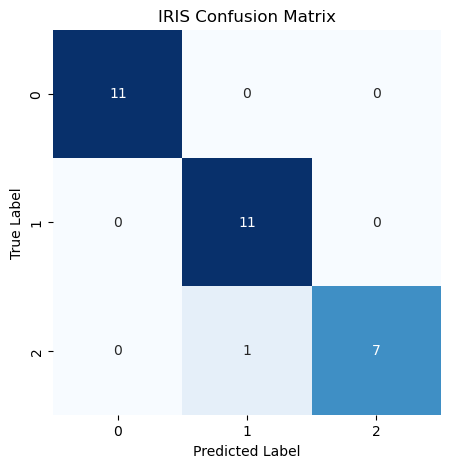

In [472]:
# confusion matrix
iris_conf_matrix = confusion_matrix(y_test_iris, y_pred_iris)
# Visualize the confusion matrix using Seaborn
plt.figure(figsize=(5, 5))
n=len(np.unique(y_pred_iris))
sns.heatmap(iris_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.arange(n), yticklabels=np.arange(n))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('IRIS Confusion Matrix')
plt.show()

## Bouns: Compare the NN_Model with the Sklearn neural network

In [473]:
#Model
print(f"The IRIS Accuracy of NN_Model:{accuracy_score(y_test_iris, y_pred_iris)*100:.2f} %")

# MLPClassifier from scikit-learn on IRIS
sklearn_iris = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
sklearn_iris.fit(X_train_iris, y_train_iris)
sklearn_pred_iris = sklearn_iris.predict(X_test_iris)
print(f"The IRIS Accuracy of MLPClassifier :{accuracy_score(y_test_iris, sklearn_pred_iris)*100:.2f} %")

The IRIS Accuracy of NN_Model:96.67 %
The IRIS Accuracy of MLPClassifier :100.00 %


## Bouns: Compare the NN_Model with the Keras Neural Network

In [474]:
# NN_Model
print(f"The IRIS Accuracy of NN_Model:{accuracy_score(y_test_iris, y_pred_iris)*100:.2f} %")

# Keras Model
keras_iris = Sequential()
keras_iris.add(Dense(units=8, activation='sigmoid', input_dim=4))
keras_iris.add(Dense(units=3, activation='softmax'))
keras_iris.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
targets_train_iris = LabelBinarizer().fit_transform(y_train_iris)
keras_iris.fit(X_train_iris, targets_train_iris, epochs=1000, batch_size=8, verbose=0)
keras_accuracy_iris = keras_iris.evaluate(X_test_iris, LabelBinarizer().fit_transform(y_test_iris), verbose=0)[1]
print(f"The IRIS Accuracy of Keras Model: {keras_accuracy_iris * 100:.2f}%")

The IRIS Accuracy of NN_Model:96.67 %
The IRIS Accuracy of Keras Model: 100.00%


## NN Model Testing on MNIST Dataset 

In [475]:
#Loading & spliting Data
mnist = datasets.load_digits()
# Separate features (X) and target labels (y)
X = mnist.data
y = mnist.target
X, y = shuffle(X, y, random_state=42) # Shuffle the data 
scaler = StandardScaler() # Initialize a StandardScaler to standardize the feature values
X = scaler.fit_transform(X) # Fit the scaler to the features and transform them
# Split the data into training and testing sets
X_train_minist, X_test_minist, y_train_minist, y_test_minist = train_test_split(X, y, test_size=0.2, random_state=42)

In [476]:
# Model_test
y_pred_minist=NN(X_train_minist,y_train_minist,X_test_minist,eta = 1, N_Max = 1000, prec_err_enhc = 0.1, accuracy = 0.98, n = 1)
print(f"The final_Acuarrcy of NN_Model:{accuracy_score(y_test_minist, y_pred_minist)*100:.6f} %")

F:\Anconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


The final_Acuarrcy of NN_Model:88.055556 %


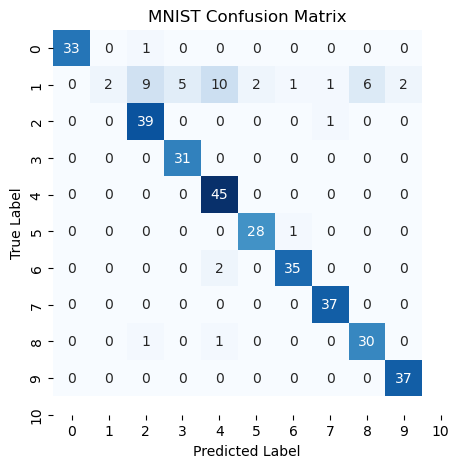

In [477]:
# confusion matrix
minist_conf_matrix = confusion_matrix(y_test_minist, y_pred_minist)
# Visualize the confusion matrix using Seaborn
n=len(np.unique(y_pred_minist))
plt.figure(figsize=(5, 5))
sns.heatmap(minist_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.arange(n+1), yticklabels=np.arange(n+1))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('MNIST Confusion Matrix')
plt.show()

## Bouns: Compare the model with the Sklearn neural network

In [478]:
print(f"The MINST Accuracy of NN_Model:{accuracy_score(y_test_minist, y_pred_minist)*100:.2f} %")
# MLPClassifier from scikit-learn on MINST
sklearn_minist = MLPClassifier(hidden_layer_sizes=(128, ), max_iter=1000, random_state=42)
sklearn_minist.fit(X_train_minist, y_train_minist)
sklearn_pred_minist = sklearn_minist.predict(X_test_minist)
print(f"The MNIST Accuracy of MLPClassifier: {accuracy_score(y_test_minist, sklearn_pred_minist) * 100:.2f}%")

The MINST Accuracy of NN_Model:88.06 %
The MNIST Accuracy of MLPClassifier: 97.78%


## Bouns: Compare the NN_Model with the Keras Neural Network

In [479]:
# NN_Model
print(f"The MINST Accuracy of NN_Model:{accuracy_score(y_test_minist, y_pred_minist)*100:.2f} %")
# Keras Model
keras_minist = Sequential()
keras_minist.add(Dense(units=128, activation='sigmoid', input_dim=64))  # Change input_dim to match the number of features
keras_minist.add(Dense(units=10, activation='softmax'))
keras_minist.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

if len(y_train_minist) != 10:
    y_train_minist_categorical = to_categorical(y_train_minist, num_classes=10)
    y_test_minist_categorical = to_categorical(y_test_minist, num_classes=10)
else:
    y_train_minist_categorical = y_train_minist
    y_test_minist_categorical = y_test_minist

keras_minist.fit(X_train_minist, y_train_minist_categorical, epochs=5, batch_size=32, verbose=0)
keras_accuracy_minist = keras_minist.evaluate(X_test_minist, LabelBinarizer().fit_transform(y_test_minist_categorical), verbose=0)[1]
print(f"The MNIST Accuracy of Keras Model: {keras_accuracy_minist * 100:.2f}%")

The MINST Accuracy of NN_Model:88.06 %
The MNIST Accuracy of Keras Model: 96.67%
